### Preprocessing

In [116]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

with open('processed_posts.pkl', 'rb') as pf:
    posts = pickle.load(pf)

In [117]:
labelsByPost = []
postsByPost = []

for i in range(0, len(posts)):
    for post in posts[i]:
        labelsByPost.append(labels[i])
        postsByPost.append(post)

In [118]:
# Tokenizing data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_features = 10000
max_len = 25
batch_size = 32
max_words = 10000

In [119]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(postsByPost)
sequences = tokenizer.texts_to_sequences(postsByPost)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 75302 unique tokens


In [120]:
data = sequence.pad_sequences(sequences, maxlen=max_len)
label_dictionary = {
    'I': 0,
    'E': 1
}

labels = [label_dictionary[label[:1]] for label in labelsByPost]

In [121]:
import numpy as np
labels = np.asarray(labels)

In [122]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (383869, 25)
Shape of label tensor: (383869,)


In [123]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [124]:
e_labels = []
e_data = []
i_labels = []
i_data = []

for i in range(0, len(labels)):
    if (labels[i] == 0):
        i_labels.append(labels[i])
        i_data.append(data[i])
    if (labels[i] == 1):
        e_labels.append(labels[i])
        e_data.append(data[i])

In [125]:
mix_labels = e_labels + i_labels[:len(e_labels)]
mix_data = e_data + i_data[:len(e_data)]

In [126]:
mix_labels = np.asarray(mix_labels)
mix_data = np.asarray(mix_data)

In [127]:
indices = np.arange(mix_data.shape[0])
np.random.shuffle(indices)
mix_data = mix_data[indices]
mix_labels = mix_labels[indices]

In [128]:
x_test = mix_data[:8000]
y_test = mix_labels[:8000]

x_train = mix_data[8000:]
y_train = mix_labels[8000:]

x_val = x_train[:5000]
y_val = y_train[:5000]

partial_x_train = x_train[5000:60000]
partial_y_train = y_train[5000:60000]

In [129]:
from collections import Counter
Counter(partial_y_train)

Counter({1: 27610, 0: 27390})

In [130]:
from keras.callbacks import Callback

class True_eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.total_accuracy = []
        self.i_accuracy = []
        self.e_accuracy = []
    
    def ie_real_acc(self, prediction):
        y_true = self.validation_data[1]
        i_acc = 0
        i_total = 0
        e_acc = 0
        e_total = 0
        for i in range(0, len(prediction)):
            if (y_true[i] == 0):
                if (prediction[i].round() == y_true[i]):
                    i_acc += 1
                i_total += 1
            else:
                if (prediction[i].round() == y_true[i]):
                    e_acc += 1
                e_total += 1
        return (i_acc/i_total), (e_acc/e_total)
    

    def on_epoch_end(self, epoch, logs={}):
        x_val = self.validation_data[0]
        y_pred = self.model.predict(x_val)
        i_real_acc, e_real_acc = self.ie_real_acc(y_pred)
        print ("I Acc: %f" % i_real_acc)
        print ("E Acc: %f" % e_real_acc)
        self.i_accuracy.append(i_real_acc)
        self.e_accuracy.append(e_real_acc)

In [131]:
import os

embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [132]:
from keras import models
from keras import layers
from keras.regularizers import l1_l2
from keras.layers import Embedding, Dropout, LSTM, Dense

def build_model():
    model = models.Sequential()
    model.add(Embedding(max_features, 50, input_length=max_len))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1, activation='sigmoid'))
    
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [133]:
import tensorflow as tf
model = build_model()
with tf.device('/gpu:0'):
    true_metrics = True_eval((x_val, y_val))
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(x_val, y_val),
                        epochs=100, batch_size=256, 
                        callbacks=[true_metrics])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 18s 325us/step - loss: 0.6933 - acc: 0.5132 - val_loss: 0.6924 - val_acc: 0.5158
I Acc: 0.446166
E Acc: 0.586387
Epoch 2/100
55000/55000 [==============================] - 15s 275us/step - loss: 0.6916 - acc: 0.5226 - val_loss: 0.6933 - val_acc: 0.5140
I Acc: 0.273739
E Acc: 0.757551
Epoch 3/100
55000/55000 [==============================] - 15s 276us/step - loss: 0.6903 - acc: 0.5302 - val_loss: 0.6919 - val_acc: 0.5230
I Acc: 0.366309
E Acc: 0.681836
Epoch 4/100
55000/55000 [==============================] - 16s 283us/step - loss: 0.6889 - acc: 0.5360 - val_loss: 0.6984 - val_acc: 0.5148
I Acc: 0.883989
E Acc: 0.140556
Epoch 5/100
55000/55000 [==============================] - 16s 289us/step - loss: 0.6877 - acc: 0.5414 - val_loss: 0.6928 - val_acc: 0.5210
I Acc: 0.496226
E Acc: 0.546114
Epoch 6/100
55000/55000 [==============================] - 16s 287us/step - loss: 0.6859 - 

55000/55000 [==============================] - 16s 283us/step - loss: 0.4472 - acc: 0.7724 - val_loss: 1.1456 - val_acc: 0.5034
I Acc: 0.499801
E Acc: 0.507048
Epoch 49/100
55000/55000 [==============================] - 16s 283us/step - loss: 0.4428 - acc: 0.7717 - val_loss: 1.1981 - val_acc: 0.4996
I Acc: 0.456496
E Acc: 0.543294
Epoch 50/100
55000/55000 [==============================] - 16s 283us/step - loss: 0.4377 - acc: 0.7753 - val_loss: 1.1769 - val_acc: 0.5014
I Acc: 0.500596
E Acc: 0.502215
Epoch 51/100
55000/55000 [==============================] - 16s 284us/step - loss: 0.4326 - acc: 0.7761 - val_loss: 1.1654 - val_acc: 0.5036
I Acc: 0.497020
E Acc: 0.510270
Epoch 52/100
55000/55000 [==============================] - 16s 285us/step - loss: 0.4262 - acc: 0.7828 - val_loss: 1.1993 - val_acc: 0.5034
I Acc: 0.508145
E Acc: 0.498590
Epoch 53/100
55000/55000 [==============================] - 16s 288us/step - loss: 0.4217 - acc: 0.7856 - val_loss: 1.3009 - val_acc: 0.5018
I Acc: 

55000/55000 [==============================] - 16s 282us/step - loss: 0.2876 - acc: 0.8640 - val_loss: 2.0475 - val_acc: 0.4944
I Acc: 0.493047
E Acc: 0.495771
Epoch 96/100
55000/55000 [==============================] - 16s 284us/step - loss: 0.2828 - acc: 0.8655 - val_loss: 1.9550 - val_acc: 0.5048
I Acc: 0.483909
E Acc: 0.525977
Epoch 97/100
55000/55000 [==============================] - 16s 287us/step - loss: 0.2801 - acc: 0.8677 - val_loss: 1.9836 - val_acc: 0.5046
I Acc: 0.488677
E Acc: 0.520741
Epoch 98/100
55000/55000 [==============================] - 16s 285us/step - loss: 0.2763 - acc: 0.8672 - val_loss: 1.9788 - val_acc: 0.5016
I Acc: 0.490663
E Acc: 0.512686
Epoch 99/100
55000/55000 [==============================] - 16s 287us/step - loss: 0.2770 - acc: 0.8673 - val_loss: 1.9700 - val_acc: 0.5074
I Acc: 0.509337
E Acc: 0.505437
Epoch 100/100
55000/55000 [==============================] - 16s 289us/step - loss: 0.2730 - acc: 0.8697 - val_loss: 2.0177 - val_acc: 0.5036
I Acc:

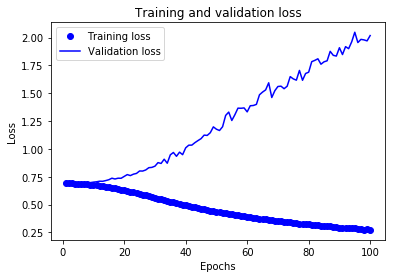

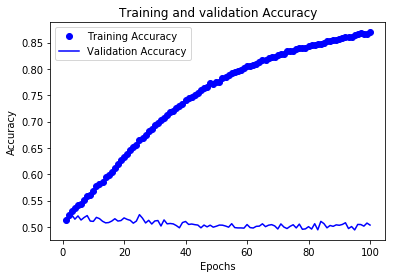

<Figure size 432x288 with 0 Axes>

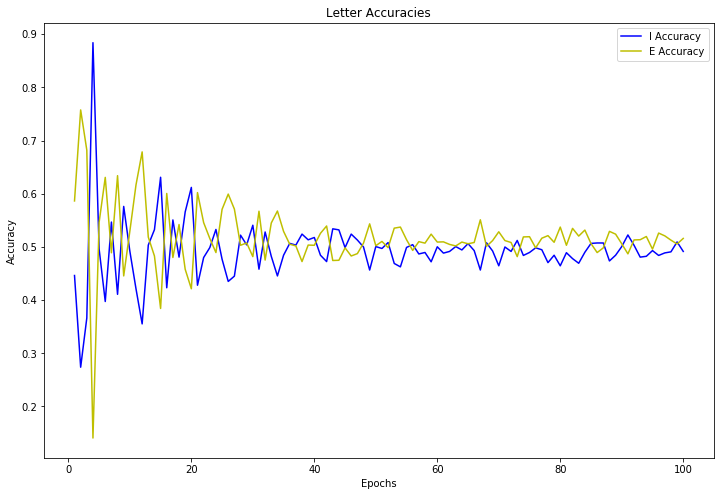

In [134]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.i_accuracy, 'b', label='I Accuracy')
plt.plot(epochs, true_metrics.e_accuracy, 'y', label='E Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()